$\newcommand{\calf}{{\cal F}}
\newcommand{\calk}{{\cal K}}
\newcommand{\calp}{{\cal P}}
\newcommand{\dnu}{d \nu}
\newcommand{\mf}{{\bf F}}
\newcommand{\md}{{\bf D}}
\newcommand{\mP}{{\bf P}}
\newcommand{\mU}{{\bf U}}
\newcommand{\vu}{{\bf u}}
\newcommand{\vx}{{\bf x}}
\newcommand{\vw}{{\bf w}}
\newcommand{\vy}{{\bf y}}
\newcommand{\vf}{{\bf f}}
\newcommand{\vs}{{\bf s}}
\newcommand{\ve}{{\bf e}}
\newcommand{\vd}{{\bf d}}
\newcommand{\vb}{{\bf b}}
\newcommand{\vg}{{\bf g}}
\newcommand{\vz}{{\bf z}}
\newcommand{\vr}{{\bf r}}
\newcommand{\mg}{{\bf G}}
\newcommand{\ml}{{\bf L}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mv}{{\bf V}}
\newcommand{\ma}{{\bf A}}
\newcommand{\mi}{{\bf I}}
\newcommand{\mm}{{\bf M}}
\newcommand{\mb}{{\bf B}}
\newcommand{\ball}{{\cal B}}
\newcommand{\ptc}{{\Psi TC}}
\newcommand{\diag}{\mbox{diag}}
\newcommand{\begeq}{{\begin{equation}}}
\newcommand{\endeq}{{\end{equation}}}
$

In [1]:
include("fanote_init.jl")

## Section 4.5:  Solver for Anderson Acceleration, aasol.jl

Contents for Section 4.5

[Overview](#Overview)

[aasol.jl](#Section-4.5.1:-aasol.jl)

[Mixing](#Section-4.5.2:-The-mixing-parameter-$\beta$)

[Projects](#Section-4.6:-Projects)

### Overview

As usual, we begin with the docstrings. You should not expect the iteration statistics to agree to high precision across operating systems because the optimization problems are so ill-conditioned. This is especially the case with the example from 
<cite data-cite="ctk:alex1"><a href="siamfa.html#ctk:alex1">(TK15)</cite>.

### Section 4.5.1: aasol.jl

In [2]:
? aasol

search: aasol nsol ptcsol



aasol(GFix!, x0, m, Vstore; maxit=20,       rtol=1.e-10, atol=1.e-10, beta=1.0, pdata=nothing, keepsolhist = false)

C. T. Kelley, 2022

Julia code for Anderson acceleration. Nothing fancy.

Solvers fixed point problems x = G(x).

You must allocate storage for the function and fixed point map history –> in the calling program <– in the array Vstore.

For an n dimensional problem with Anderson(m), Vstore must have at least 2m + 4 columns and 3m + 3 is better.  If m=0 (Picard) then V must have at least 4 columns.

Inputs:

  * GFix!: fixed-point map, the ! indicates that GFix! overwrites G, your   preallocated storage for the function value G=G(xin).

    So G=GFix!(G,xin) or G=GFix!(G,xin,pdata) returns   G=G(xin).

    Your GFix function MUST end with –> return G <–. See the example   in the docstrings.
  * x0: Initial iterate. It is a vector of size N

    You should store it as (N) and design G! to use vectors of size (N). If you use (N,1) consistently instead, the solvers may work, but I make no guarantees.
  * m: depth for Anderson acceleration. m=0 is Picard iteration
  * Vstore: Working storage array. For an n dimensional problem Vstore should have at least 3m+3 columns unless you are storage bound. If storage is a problem, then you can allocate a minimum of 2m+4 columns. The smaller allocation exacts a performance penalty, especially for small problems and small values of m. So for Anderson(3), Vstore should be no smaller  than zeros(N,8) with zeros(N,11) a better choice. Vstore needs to allocate for the history of differences of the residuals and fixed point maps. The extra m-1 columns are for storing intermediate results in the downdating phase of the QR factorization for the coefficient  matrix of the optimization problem. See the notebook or the print book  for the details of this mess. 

    If m=0, then Vstore needs 4 columns.

Keyword Arguments (kwargs):

maxit: default = 20

limit on nonlinear iterations

rtol and atol: default = 1.e-10

relative and absolute error tolerances

beta:

Anderson mixing parameter. Changes G(x) to (1-beta)x + beta G(x). Equivalent to accelerating damped Picard iteration. The history vector is the one for the damped fixed point map, not the original one. Keep this in mind when comparing results.

pdata:

precomputed data for the fixed point map. Things will go better if you use this rather than hide the data in global variables within the module for your function.

keepsolhist: default = false

Set this to true to get the history of the iteration in the output tuple. This is on by default for scalar equations and off for systems. Only turn it on if you have use for the data, which can get REALLY LARGE.

Output:

  * A named tuple (solution, functionval, history, stats, idid,              errcode, solhist)

where

– solution = converged result

– functionval = G(solution)       You might want to use functionval as your solution since it's       a Picard iteration applied to the converged Anderson result. If G       is a contraction it will be better than the solution.

– history = the vector of residual norms (||x-G(x)||) for the iteration

– stats = named tuple (condhist, alphanorm) of the history of the               condition numbers of the optimization problem               and l1 norm of the coefficients. 

This is only for diagnosing problems and research. Condihist[k] and alphanorm[k] are the condition number and coefficient norm for the optimization problem that computes iteration k+1 from iteration k. 

I record this for iterations k=1, ... until the final iteration  K. So I do not record the stats for k=0 or the final iteration.  We did record the data for the final iteration in Toth/Kelley  2015 at the cost of an extra optimization problem solve.  Since we've already terminated, there's not any point in  collecting that data.

Bottom line: if history has length K+1 for iterations  0 ... K, then condhist and alphanorm have length K-1.

– idid=true if the iteration succeeded and false if not.

– errcode = 0 if the iteration succeeded

```
    = -1 if the initial iterate satisfies the termination criteria

    = -2 if || residual || > div_test || residual_0 ||
         I have fixed div_test = 1.e4 for now. I terminate 
         the iteration when this happens to avoid generating 
         Infs and/or NaNs.

    = 10 if no convergence after maxit iterations
```

– solhist:

This is the entire history of the iteration if you've set keepsolhist=true

solhist is an N x K array where N is the length of x and K is the number of iterations + 1. 

### Examples for aasol

#### Duplicate Table 1 from Toth-Kelley 2015.

The final entries in the condition number and coefficient norm statistics are never used in the computation and we don't compute them in Julia. See the docstrings, notebook, and the print book for the story on this.

```jldoctest
julia> function tothk!(G, u)
       G[1]=cos(.5*(u[1]+u[2]))
       G[2]=G[1]+ 1.e-8 * sin(u[1]*u[1])
       return G
       end
tothk! (generic function with 1 method)

julia> u0=ones(2,); m=2; vdim=3*m+3; Vstore = zeros(2, vdim);
julia> aout = aasol(tothk!, u0, m, Vstore; rtol = 1.e-10);
julia> aout.history
8-element Vector{Float64}:
 6.50111e-01
 4.48661e-01
 2.61480e-02
 7.25389e-02
 1.53107e-04
 1.18513e-05
 1.82466e-08
 1.04725e-13

julia> [aout.stats.condhist aout.stats.alphanorm]
6×2 Matrix{Float64}:
 1.00000e+00  1.00000e+00
 2.01556e+10  4.61720e+00
 1.37776e+09  2.15749e+00
 3.61348e+10  1.18377e+00
 2.54948e+11  1.00000e+00
 3.67694e+10  1.00171e+00
```

Now we put a mixing or damping parameter in there with beta = .5. This example is nasty enough to make mixing do well. Keep in mind that the history is for the damped residual, not the original one.

```
julia> bout=aasol(tothk!, u0, m, Vstore; rtol = 1.e-10, beta=.5);

julia> bout.history
7-element Vector{Float64}:
 3.25055e-01
 3.70140e-02
 1.81111e-03
 9.55308e-04
 1.25936e-05
 1.40854e-09
 2.18196e-12
```

#### H-equation example with m=2.

This takes more iterations than Newton, which should surprise no one.

```jldoctest
julia> n=16; x0=ones(n,); Vstore=zeros(n,20); m=2;
julia> hdata=heqinit(x0,.99);
julia> hout=aasol(HeqFix!, x0, m, Vstore; pdata=hdata);
julia> hout.history
12-element Vector{Float64}:
 1.47613e+00
 7.47800e-01
 2.16609e-01
 4.32017e-02
 2.66867e-02
 6.82965e-03
 2.70779e-04
 6.51027e-05
 7.35581e-07
 1.85649e-09
 4.94803e-10
 5.18866e-12

```


### Section 4.5.2: The mixing parameter $\beta$

In this section we show how the mixing parameter can be used to make the fixed point map __hardleftFix!__ (see Section 4.4) for the convection-diffusion example contractive. You will see that the cost for that mixing is high.

We will use a mixing parameter $\beta = .2$ The code for this example is __mixing_pde.jl__ in the __src/Chapter4__ directory in the notebook repository. We will compare $m=0, 2, 4, 10$. $m=0$ (Picard) failed to converge for the undamped problem, but does converge, albeit slowly, here.

Failure to converge after 100 iterations for m=0 in aasol.jl


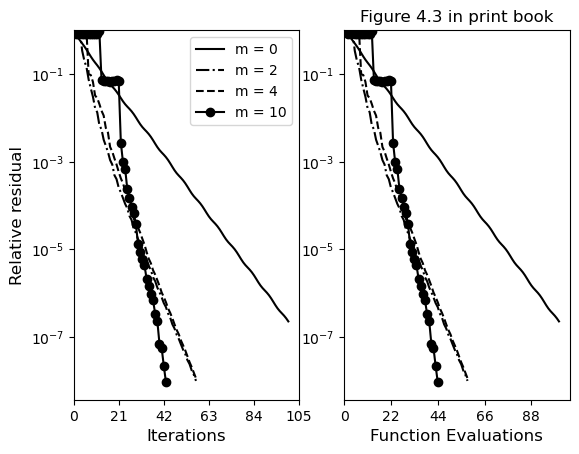

In [3]:
mixing_pde();

While the mixing parameter of $.2$ makes the map $\mg_\beta$ a contraction, the performance of the iteration is
not as good as the unmixed iteration from __Figure 4.2__. You should be aware that the residual in the figure
is the residual $\mf_\beta(\vx) = \vx - \mg_\beta(\vx)$, which is not the same as the residual reported in
__Figure 4.2__. The residual histories still tell an accurate story.
The message here is that mixing will not solve all your 
problems. 

### Section 4.5.3: Benchmarking

The examples in this chapter are integral equations. The H-equation is clearly an integral equations and the
left preconditioned convection diffusion equation is as well. These problems are good candidates for Anderson
acceleration, as the title of
<cite data-cite="Anderson1965"><a href="siamfa.html#Anderson1965">(And65)</cite> indicates. So, it should not be
a complete surprise that Anderson acceleration performs very well for these problems.
    
We begin with the H-equation and compare the previous best solver, Newton-GMRES with the Eisenstat-Walker forcing term with Anderson acceleration. The difference in timings is what one would expect from the difference in
function evaluations one sees in __Figure 4.1__.

In [4]:
n=4096; m=3;
# Initialize. Set up the kwargs.
FS=ones(n,); FPK=ones(n,10); Vstore=zeros(n,3*m+3); 
x0=ones(n,); c=.5; hdata = heqinit(x0, c);
kbargsew=(atol = 1.e-10, rtol = 1.e-10, eta=.9, 
    fixedeta=false, pdata=hdata);
aaargs=(atol = 1.e-10, rtol = 1.e-10, 
    pdata=hdata, maxit=20);
# Run the solvers
println("Newton-GMRES, Eisenstat-Walker"); 
@btime nsoli(heqf!, $x0, $FS, $FPK; kbargsew...);
println("Anderson acceleration"); 
@btime aasol(HeqFix!, $x0, $m, $Vstore; aaargs...);

Newton-GMRES, Eisenstat-Walker
  1.151 ms (404 allocations: 499.52 KiB)
Anderson acceleration
  606.000 μs (279 allocations: 402.34 KiB)


__Figure 4.2__ indicates that $m=10$ is the best choice for Anderson acceleration
for the left-preconditioned convection-diffusion
equation. We compare that with Newton-GMRES. The results are closer than for the H-equation with Newton-GMRES
performing slightly better. One reason for this is that the initial iterate is poor and Newton-GMRES is better
able to handle that than Anderson acceleration. Function evaluations are inexpensive for this example, so that is 
a less reliable indicator of performance than it is for the H-equation.

We also show that mixing makes the performance of Anderson acceleration worse. 

In [5]:
np=31; mp=10; N=np*np;
# Initialize. Set up the kwargs.
pdata=pdeinit(np); fdata=pdata.fdata;
u0=zeros(N); FV=copy(u0); JV=zeros(N,20); 
Vstore=zeros(N,3*mp+3); atol=1.e-8; rtol=1.e-8;
kbargs=(pdata=pdata, rtol=rtol, atol=atol, 
    maxit=20, eta=.1, fixedeta=false);
aaargs=(pdata=pdata, rtol=rtol, atol=atol, maxit=40);
baargs=(pdata=pdata, rtol=rtol, atol=atol,
    maxit=100, beta=.2);
println("Newton-GMRES, Eisenstat-Walker"); 
@btime nsoli(hardleft!, $u0, $FV, $JV; kbargs...);
println("Anderson acceleration"); 
@btime aasol(hardleftFix!, $u0, $mp, $Vstore; aaargs...);
println("Anderson acceleration with mixing"); 
@btime aasol(hardleftFix!, $u0, $mp, $Vstore; baargs...);

Newton-GMRES, Eisenstat-Walker
  1.150 ms (975 allocations: 173.34 KiB)
Anderson acceleration
  994.917 μs (1098 allocations: 510.03 KiB)
Anderson acceleration with mixing
  2.408 ms (2502 allocations: 1.15 MiB)


The reader should play with the parameters for both __nsoli__ and __aasol__ in these examples. Do changes in the
parameters change anything?

## Section 4.6: Projects

### More on mixing

See how mixing affects the performance of Anderson acceleration for the H-equation. Begin with $\beta = .9$ and see if any value of $\beta$ is better than no mixing at all. 

### Explaining results

Can you explain why Anderson acceleration did so well in __Section 4.4.2__? Do the results from 
<cite data-cite="pollock3"><a href="siamfa.html#pollock3">(PR21)</cite> apply to this case? 

### The EDIIS algorithm (not easy!)

- (easy part) Write a brute-force Anderson acceleration code that uses the formulation in __Algorithm 4.1__ and 
solves the optimization problem by solving the normal equations. How does the solver respond to the ill-conditioning in the examples from the text? 

- The EDIIS 
<cite data-cite="Kudin2002"><a href="siamfa.html#Kudin2002">(KSC02)</cite>,
<cite data-cite="ctk:ediis"><a href="siamfa.html#ctk:ediis">(CK19)</cite>
method adds a nonnegativity constraint to the optimiztion problem for
Anderson acceleration. Modify your brute force code to use the EDIIS algorithm. The nasty part of 
this problem is to pick a solver for the optimization problem that can deal with the ill-conditioning. The obvious 
choice is the trust-region method from
<cite data-cite="colelilsq"><a href="siamfa.html#colelilsq">(CL96)</cite>, which is in current versions of
Matlab, for example. A choice less sensitive to ill-conditioning is the method from
<cite data-cite="golubsaunders"><a href="siamfa.html#golubsaunders">(GS69)</cite>, which was in older
versions of Matlab.
Look at <cite data-cite="ctk:ediis"><a href="siamfa.html#ctk:ediis">(CK19)</cite> for some discussion and
an example with the H-equation. Repeat that example for the convection-diffusion problem.



## Next notebook = [Chapter 5: Case Studies](SIAMFANLCh5.ipynb)